In [1]:
import yfinance as yf
import pandas as pd
import datetime
from statistics import mean
import matplotlib.pyplot as plt #pyplot package under the matplotlib package
import seaborn as sns
import math

plt.style.use("ggplot")
 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [66]:
ticker = yf.Ticker("ddog")

In [69]:
ticker.info["longBusinessSummary"]
# ticker.info["logo_url"]

"Datadog, Inc. provides monitoring and analytics platform for developers, information technology operations teams, and business users in the cloud in North America and internationally. The company's SaaS platform integrates and automates infrastructure monitoring, application performance monitoring, log management, and security monitoring to provide real-time observability of its customers technology stack. Its platform also provides user experience monitoring, network performance monitoring, cloud security, developer-focused observability, and incident management, as well as a range of shared features, such as dashboards, analytics, collaboration tools, and alerting capabilities. The company was incorporated in 2010 and is headquartered in New York, New York."

# set user input parameters

In [70]:
risk_free_rate = 0.0302

In [71]:
market_return_rate = 0.1

In [72]:
cap_growth = 1.15

In [73]:
current_year = "2022"

# Custom functions 

In [74]:
def clean_dataframe(frame):
    frame = frame.T.rename_axis('year').reset_index()
    frame["year"] = pd.DatetimeIndex(frame["year"]).year
    frame = frame.sort_values(by=['year'], ascending=False)
    frame.fillna(0, inplace=True)
    return frame

In [75]:
def get_DCF_value(history):
    #create empty growth list
    growth_history = []
    
    #calculate the growth between each year. add to the list
    for i in range(0,(len(ocf_history)-1)):
        growth = (history[i] - history[i+1]) / abs(history[i+1])    
        growth_history.append(growth)
    
    #get the average growth
    average_growth_rate = 1 + mean(growth_history)
    
    #for year 4-10, if average growth in year 1-3 is more than 15%, cap it at 15%
    if average_growth_rate > cap_growth: 
        average_growth_rate_cap = cap_growth
    else: 
        average_growth_rate_cap = average_growth_rate
        
    #project future cash flow (loop properly)
    future_value = []
    start_value = history[0]
    for i in range(1, 11):
        #for year 1 - 3, grow by average growth rate
        if i <= 3:
            value =  start_value * average_growth_rate
            future_value.append(value)
            start_value = value
        #for year 4-10, grow by cap growth rate
        elif i > 3:
            value =  start_value * average_growth_rate_cap
            future_value.append(value)
            start_value = value

    # convert future values into present value and sum them
    present_value = 0 

    for i in range(0, len(future_value)):
        value = future_value[i] / pow(wacc, (i+1))
        present_value += value
    
    #calculate present value per share
    fair_value = present_value/shares
    
    return fair_value

In [76]:
def get_cagr_DCF_value(history):
    #calculate CAGR
    base = history[0] / history[-1]
    power = 1/(len(history)-1)
    average_growth_rate = math.pow(base, power)

 #for year 4-10, if average growth in year 1-3 is more than 15%, cap it at 15%
    if average_growth_rate > cap_growth: 
        average_growth_rate_cap = cap_growth
    else: 
        average_growth_rate_cap = average_growth_rate
        
    #project future cash flow (loop properly)
    future_value = []
    start_value = history[0]
    for i in range(1, 11):
        #for year 1 - 3, grow by average growth rate
        if i <= 3:
            value =  start_value * average_growth_rate
            future_value.append(value)
            start_value = value
        #for year 4-10, grow by cap growth rate
        elif i > 3:
            value =  start_value * average_growth_rate_cap
            future_value.append(value)
            start_value = value

    # convert future values into present value and sum them
    present_value = 0 

    for i in range(0, len(future_value)):
        value = future_value[i] / pow(wacc, (i+1))
        present_value += value
    
    #calculate present value per share
    fair_value = present_value/shares
    
    return fair_value

In [77]:
def DCF_valuation_report(history):
    print("based on average year-on-year growth, intrinsic value is: {}".format(get_DCF_value(history)))
    try:
        print("based on CAGR, intrinsic value is: {}".format(get_cagr_DCF_value(history)))
    except ValueError: 
        print("CAGR growth calculation impossible as first year is negative value")

In [78]:
def perpetual_growth_valuation(history):
    growth_history = []
    
    #calculate the growth between each year. add to the list
    for i in range(0,(len(history)-1)):
        growth = (history[i] - history[i+1]) / abs(history[i+1])    
        growth_history.append(growth)

    #get the minimum growth
    min_growth_rate = 1 + min(growth_history)

    #bring to current year and then project for next year. assuming we missed this year's payment
    next_payment = history[0] * min_growth_rate * min_growth_rate 

    #apply formula
    valuation = next_payment / (wacc - min_growth_rate)
    return valuation

In [79]:
def plot_value(name, function, history, color):
    try:
        plt.barh([name], function(history), color=color)
    except ValueError: 
        pass

# Download fundementals

In [80]:
shares = ticker.info["sharesOutstanding"]
market_cap = ticker.info["marketCap"]
beta = ticker.info["beta"]
current_price = ticker.info['regularMarketPrice']
book_value = ticker.info["bookValue"]

# download and clean statements

In [81]:
## income statement 
IS = ticker.financials
IS = clean_dataframe(IS)

## balance sheet
BS = ticker.balance_sheet
BS = clean_dataframe(BS)

## cashflow statement
CF = ticker.cashflow
CF = clean_dataframe(CF)

## combined  dataset
df = pd.merge(IS, BS, on="year")
df = df.merge(CF, on= "year")
df["year"] = df['year'].astype(str)

In [82]:
#create total debt column
debt_types = ["Short Long Term Debt","Long Term Debt"] 
df["total_debt"] = 0

for i in debt_types:
    if (i in df.columns) == True:
        df["total_debt"]  += df[i]

In [83]:
#free cash flow
df["FCF"]= df['Operating Cash Flow'] + df['Capital Expenditure']

#Return on Equity
df["ROE"] = df["Net Income"] / df["Stockholders Equity"]

#current ratio
df['current_ratio'] = df['Current Assets'] / df['Current Liabilities']

#debt_to_equity
df["debt_to_equity"] = df["total_debt"] / df['Stockholders Equity']

# Charts 

In [84]:
axis = list(df["year"])
axis = sorted(axis)
axis

['2019', '2020', '2021']

## cashflows

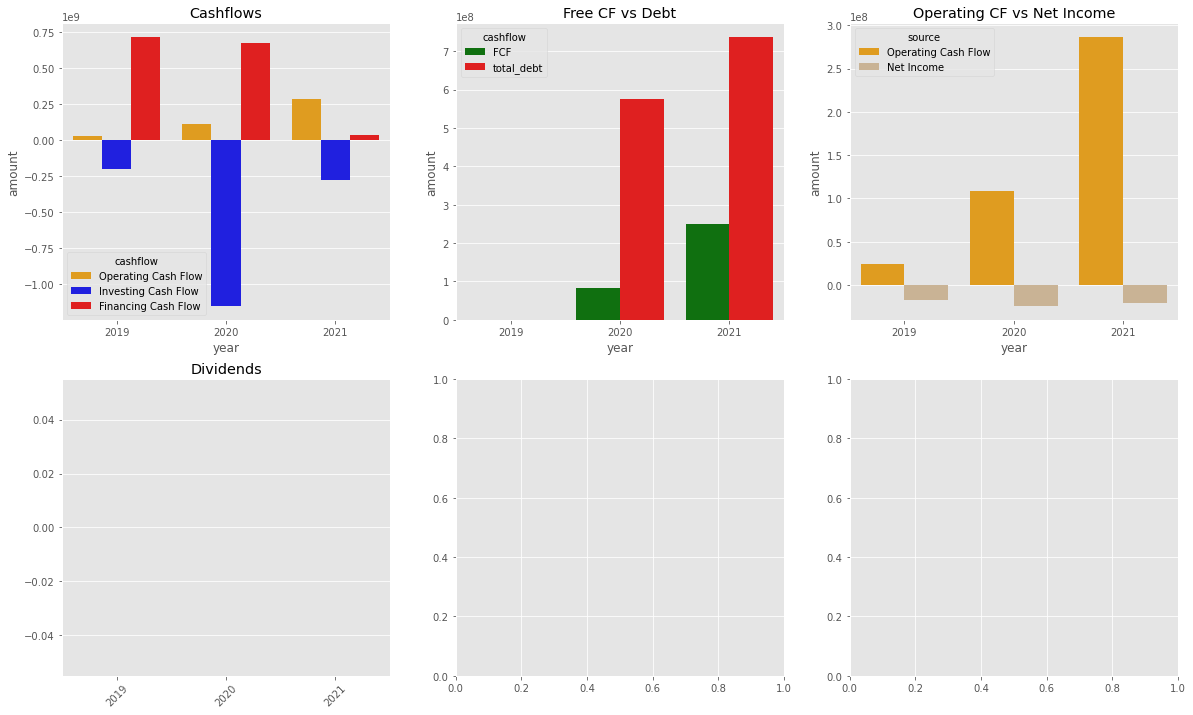

In [85]:
fig, axes = plt.subplots(2, 3,figsize=(20,12))


cashflow_df = df[["year","Operating Cash Flow","Investing Cash Flow", "Financing Cash Flow"]]
cashflow_df = cashflow_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
sns.barplot(x= "year", y="amount", data= cashflow_df, hue = "cashflow", palette = ["orange", "blue", "red"], order=axis, ax=axes[0,0])
axes[0,0].set(title="Cashflows")

fcf_df = df[["year","FCF", "total_debt"]]
fcf_df = fcf_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
sns.barplot(x= "year", y="amount", data=fcf_df, hue = "cashflow", palette = ["green", "red"], order=axis, ax=axes[0,1])
axes[0,1].set(title="Free CF vs Debt")

cashflow_income= df[["year","Operating Cash Flow",'Net Income']]
cashflow_income = cashflow_income.melt(id_vars="year",var_name="source",value_name="amount")
sns.barplot(x="year", y="amount", data=cashflow_income, hue = "source", palette = ["orange", "tan"], order=axis,ax=axes[0,2])
axes[0,2].set(title="Operating CF vs Net Income")


#dividends already adjusted for stock split according to yahoo finance
dividend_history = ticker.actions
dividend_history = dividend_history.rename_axis('year').reset_index()
dividend_history["year"] = pd.DatetimeIndex(dividend_history["year"]).year
dividend_history = dividend_history[dividend_history["Stock Splits"]==0]
dividend_history = dividend_history[["year", "Dividends"]]
dividend_history = dividend_history.groupby("year").sum()

if len(dividend_history)>0:
    sns.barplot(x = "year", y= "Dividends", data=dividend_history.reset_index(), color = "skyblue", ax=axes[1,0])
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].set(title="Dividends")
else:
    sns.barplot(x = axis, y=[0] * len(axis) ,color = "skyblue", ax=axes[1,0])
    axes[1,0].tick_params(axis='x', rotation=45)   
    axes[1,0].set(title="Dividends")
    
# #to add FCF/Debt in 2nd graph

# # add revenue vs gross profit vs net income

## balancesheet

[Text(0.5, 1.0, 'Current Ratio and Debt to Equity')]

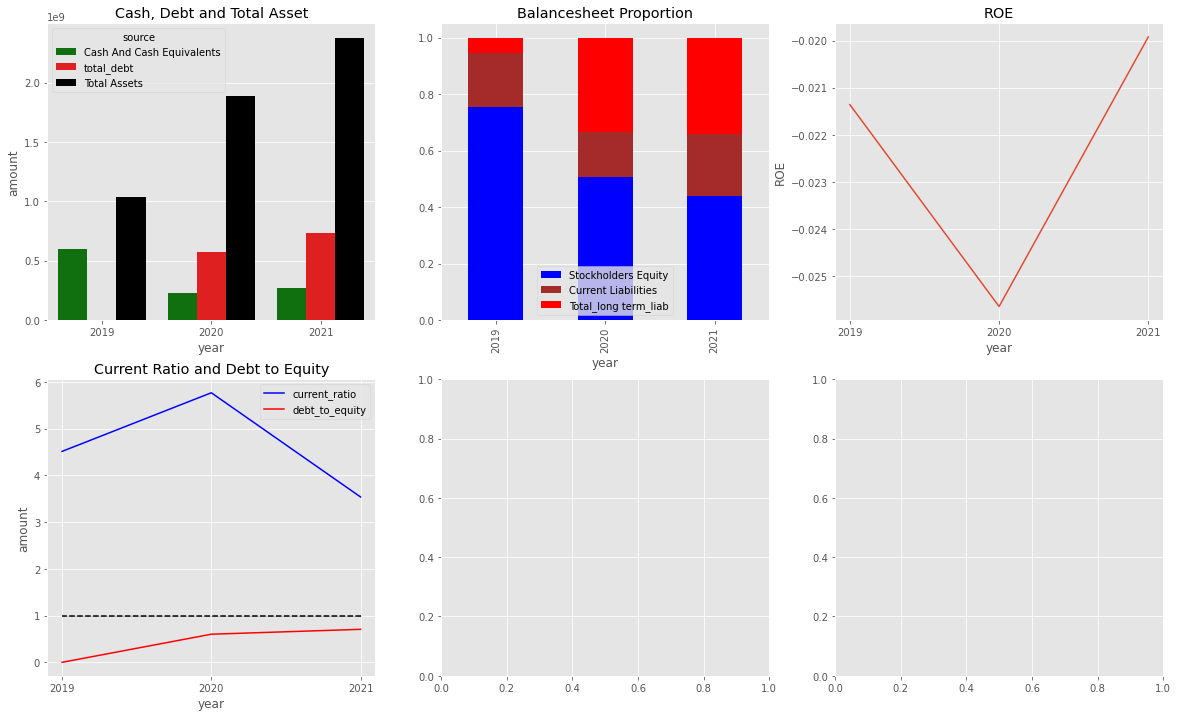

In [86]:
fig2, axes = plt.subplots(2, 3,figsize=(20,12))

balancesheet_prop= df[["year",'Cash And Cash Equivalents', "total_debt", 'Total Assets']]
balancesheet_prop = balancesheet_prop.melt(id_vars="year",var_name="source",value_name="amount")
sns.barplot(x ="year",y= "amount", data=balancesheet_prop, hue = "source", palette = ["green", "red", 'black', "black"], order=axis,ax=axes[0,0])
axes[0,0].set(title="Cash, Debt and Total Asset")

balancesheet_df = BS[["year",'Stockholders Equity','Current Liabilities','Total Liabilities Net Minority Interest']]
balancesheet_df["Total_long term_liab"] = balancesheet_df["Total Liabilities Net Minority Interest"] - balancesheet_df["Current Liabilities"] 
balancesheet_df.drop("Total Liabilities Net Minority Interest",axis="columns", inplace =True)
balancesheet_df = balancesheet_df.set_index("year").sort_index()
balancesheet_df = balancesheet_df.div(balancesheet_df.sum(axis=1), axis=0)
balancesheet_df.plot(kind='bar', stacked=True, color=['blue', 'brown', 'red'], ax=axes[0,1])
axes[0,1].set(title="Balancesheet Proportion")

sns.lineplot(x=df["year"], y= df["ROE"], ax=axes[0,2])
axes[0,2].invert_xaxis()
axes[0,2].set(title="ROE")

bs_ratio_df = df[["year","current_ratio", "debt_to_equity"]]
bs_ratio_df = bs_ratio_df.melt(id_vars="year",var_name="ratio",value_name="amount")
sns.lineplot(x= bs_ratio_df["year"], y= bs_ratio_df["amount"],hue=bs_ratio_df["ratio"], palette=["blue", "red"], ax=axes[1,0])
sns.lineplot(x= bs_ratio_df["year"], y=1, color = "black", linestyle="--", ax=axes[1,0])
axes[1,0].invert_xaxis()
axes[1,0].set(title="Current Ratio and Debt to Equity")

# WACC calculations

## Extract lates year data

In [87]:
latest_year = df.iloc[0]

## debt section 

In [88]:
debt = latest_year["total_debt"]

total_wacc_value = debt + market_cap
total_wacc_value

debt_weight = debt/total_wacc_value

if abs(latest_year['Interest Expense Non Operating']) != 0 and debt!=0:
    debt_cost = abs(latest_year['Interest Expense Non Operating']) / debt
elif abs(latest_year['Interest Expense Non Operating']) == 0 and debt==0:
    debt_cost = 0
elif abs(latest_year['Interest Expense Non Operating']) != 0 and debt==0:
    debt_cost = 0
else:
    debt_cost = 0

tax_rate = latest_year['Tax Provision'] / latest_year['Pretax Income']

In [89]:
total_wacc_value

21675389072.0

## equity section

In [90]:
if beta == None:
    beta = 1
beta

1.02013

In [91]:
equity_weight =  market_cap/total_wacc_value

equity_cost = risk_free_rate +  beta*(market_return_rate-risk_free_rate)
equity_cost

0.101405074

## WACC

In [92]:
wacc = ((equity_weight * equity_cost) + (debt_weight * debt_cost * (1-tax_rate))) + 1
wacc

1.09905794355201

# Discounted Growth Model

## a) Cashflow

In [93]:
# averge growth rate
ocf_history = list(df['Operating Cash Flow'])
DCF_valuation_report(ocf_history)

based on average year-on-year growth, intrinsic value is: 328.87445842598265
based on CAGR, intrinsic value is: 295.893707396367


## b) Income

In [94]:
ic_history = list(df['Net Income Common Stockholders'])
DCF_valuation_report(ic_history)

based on average year-on-year growth, intrinsic value is: -0.21732024699400812
based on CAGR, intrinsic value is: -0.7664885992090803


## c) Free Cash Flow

In [95]:
fcf_history = list(df["FCF"])
DCF_valuation_report(fcf_history)

based on average year-on-year growth, intrinsic value is: 966535.544795518
based on CAGR, intrinsic value is: 34564.57989466167


# Dividend Discount Model 

## a) perpetual dividend growth 

In [96]:
#get the only completed years with all dividends paid out. Company with fiscal year at the start of year still haven't 
#completed dividend pay out for the year
dividend_year = []
if axis[-1] == current_year:
    for i in range(0, len(axis)): 
        dividend_year.append(int(axis[i])-1)
        print(dividend_year[i])
else: 
    dividend_year = [int(year) for year in axis]

In [97]:
if len(dividend_history)>0:
    #filter the last 4 years of dividends payment
    dividend_history = dividend_history[dividend_history.index.isin(dividend_year)]
    dividend_history = dividend_history.sort_index(ascending=False)
    dividend_history = list(dividend_history["Dividends"])
    DDM_valuation = perpetual_growth_valuation(dividend_history)
else: 
    DDM_valuation = 0
 
print("past 4 complete yearly dividend payout are: ", dividend_history)
print("DDM valuations is: ", DDM_valuation)

past 4 complete yearly dividend payout are:  Empty DataFrame
Columns: [Dividends]
Index: []
DDM valuations is:  0


### b) perpetual FCF growth

In [98]:
PFCF_valuation = perpetual_growth_valuation(fcf_history)/shares
print("Assuming perpetual FCF growth at last 3 years' rate. Valuation is: {}".format(PFCF_valuation))

Assuming perpetual FCF growth at last 3 years' rate. Valuation is: -4.067408449132428


# Valuation Comparison

<BarContainer object of 1 artists>

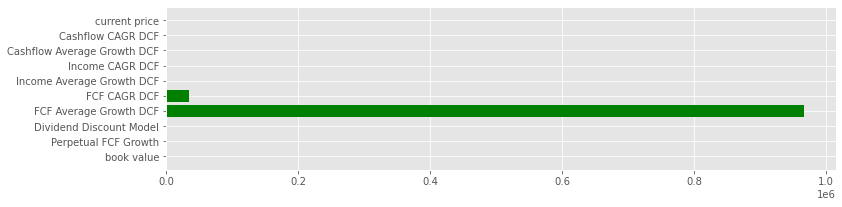

In [102]:
ax = plt.figure(figsize=(12, 3))

plt.barh("book value", book_value, color="grey")

plt.barh("Perpetual FCF Growth", PFCF_valuation, color="green")
plt.barh("Dividend Discount Model", DDM_valuation, color="skyblue")

plot_value("FCF Average Growth DCF", get_DCF_value, fcf_history, "green")
plot_value("FCF CAGR DCF", get_cagr_DCF_value, fcf_history, "green")

plot_value("Income Average Growth DCF", get_DCF_value,ic_history, "tan")
plot_value("Income CAGR DCF", get_cagr_DCF_value,ic_history, "tan")

plot_value("Cashflow Average Growth DCF", get_DCF_value,ocf_history, "orange")
plot_value("Cashflow CAGR DCF", get_cagr_DCF_value,ocf_history, "orange")

plt.barh("current price", current_price, color="black")

# Analyst's recommendations

In [ ]:
ticker.recommendations["To Grade"]\
    .value_counts()\
    .head(8)\
    .plot(kind="barh")

# Other Matrices

In [ ]:
PE_ratio = ticker.info["trailingPE"]
PE_ratio

In [ ]:
ticker.info["trailingPegRatio"]

In [ ]:
ticker.info["payoutRatio"]

# Development area

## cashflows

In [ ]:
# axis = list(df["year"])
# axis = sorted(axis)
# axis

In [ ]:
# cashflow_df = df[["year","Total Cash From Operating Activities","Total Cashflows From Investing Activities", "Total Cash From Financing Activities"]]
# cashflow_df = cashflow_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
# sns.barplot("year", "amount", data=cashflow_df, hue = "cashflow", palette = ["orange", "blue", "red"], order=axis)

In [ ]:
# fcf_df = df[["year","FCF", "total_debt"]]
# fcf_df = fcf_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
# sns.barplot("year", "amount", data=fcf_df, hue = "cashflow", palette = ["green", "red"], order=axis)

In [ ]:
# cashflow_income= df[["year","Total Cash From Operating Activities",'Net Income Applicable To Common Shares']]
# cashflow_income = cashflow_income.melt(id_vars="year",var_name="source",value_name="amount")
# sns.barplot("year", "amount", data=cashflow_income, hue = "source", palette = ["orange", "tan"], order=axis)

## balance sheet

In [ ]:
# balancesheet_prop= df[["year",'Cash', "total_debt", 'Total Assets']]
# balancesheet_prop = balancesheet_prop.melt(id_vars="year",var_name="source",value_name="amount")
# sns.barplot("year", "amount", data=balancesheet_prop, hue = "source", palette = ["green", "red", 'black', "black"], order=axis)

In [ ]:
# balancesheet_df = BS[["year",'Total Stockholder Equity','Total Current Liabilities','Total Liab']]
# balancesheet_df["Total_long term_liab"] = balancesheet_df["Total Liab"] - balancesheet_df["Total Current Liabilities"] 
# balancesheet_df.drop("Total Liab",axis="columns", inplace =True)
# balancesheet_df = balancesheet_df.set_index("year").sort_index()
# balancesheet_df = balancesheet_df.div(balancesheet_df.sum(axis=1), axis=0)
# balancesheet_df.plot(kind='bar', stacked=True, color=['blue', 'brown', 'red'])

In [ ]:
# ax = sns.lineplot(df["year"], df["ROE"])
# ax.invert_xaxis()
# ax.set(title="ROE")
# ax.legend()

In [ ]:
# bs_ratio_df = df[["year","current_ratio", "debt_to_equity"]]
# bs_ratio_df = bs_ratio_df.melt(id_vars="year",var_name="ratio",value_name="amount")
# ax = sns.lineplot(bs_ratio_df["year"], bs_ratio_df["amount"],hue=bs_ratio_df["ratio"], palette=["blue", "red"])
# ax = sns.lineplot(bs_ratio_df["year"], 1, color = "black", linestyle="--")
# ax.invert_xaxis()
# ax.legend()

In [ ]:
ticker.info.keys()